In [1]:
import scanpy as sc

from scprint import scPrint
from scprint.tasks import Embedder, Denoiser, GNInfer

from scdataloader import Preprocessor
from scdataloader.utils import load_genes, translate

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

from scdataloader.utils import get_descendants
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

from collections import Counter
from scdataloader.utils import downsample_profile
from scipy.stats import spearmanr

from scprint.tasks import GNInfer

import gseapy as gp
from grnndata.utils import TF, mTF

from bengrn import BenGRN
from anndata import AnnData
from scdataloader.utils import load_genes

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

→ connected lamindb: jkobject/scprint2


In [2]:
ft_model = "../../../bgbeshmq.ckpt" #fine tune ESM2
classsic_model = "../../../lgd8fxlr.ckpt" # classic mask
cell_model = "../../../fed4mlos.ckpt" # cell embedding


In [16]:
m = torch.load(ft_model, map_location=torch.device('cpu'))

In [17]:
model = scPrint.load_from_checkpoint(
    ft_model, precpt_gene_emb=None, classes=m['hyper_parameters']['label_counts'],  
)#strict=False)
    #transformer="normal")
del m

FYI: scPrint is not attached to a `Trainer`.


# gene emb

In [18]:
adata_prev = AnnData(pd.DataFrame(data=model.gene_encoder[0].embeddings.weight.data.cpu().numpy(), index=model.genes, columns=list(range(512))))

In [19]:
genedf = load_genes(model.organisms)

/home/ml4ig1/Documents code/scDataLoader/scdataloader/utils.py:400: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


In [20]:
adata_prev = adata_prev[adata_prev.obs.index.isin(genedf.index)]
adata_prev.obs = genedf.loc[adata_prev.obs.index]
adata_prev.obs['isTF'] = False
adata_prev.obs.loc[genedf.symbol.isin(TF) | genedf.symbol.isin(mTF), 'isTF'] = True
adata_prev

AnnData object with n_obs × n_vars = 44741 × 512
    obs: 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'synonyms', 'description', 'organism_id', 'mt', 'ribo', 'hb', 'organism', 'isTF'

/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
... storing 'symbol' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'description' as categorical
... storing 'organism' as categorical


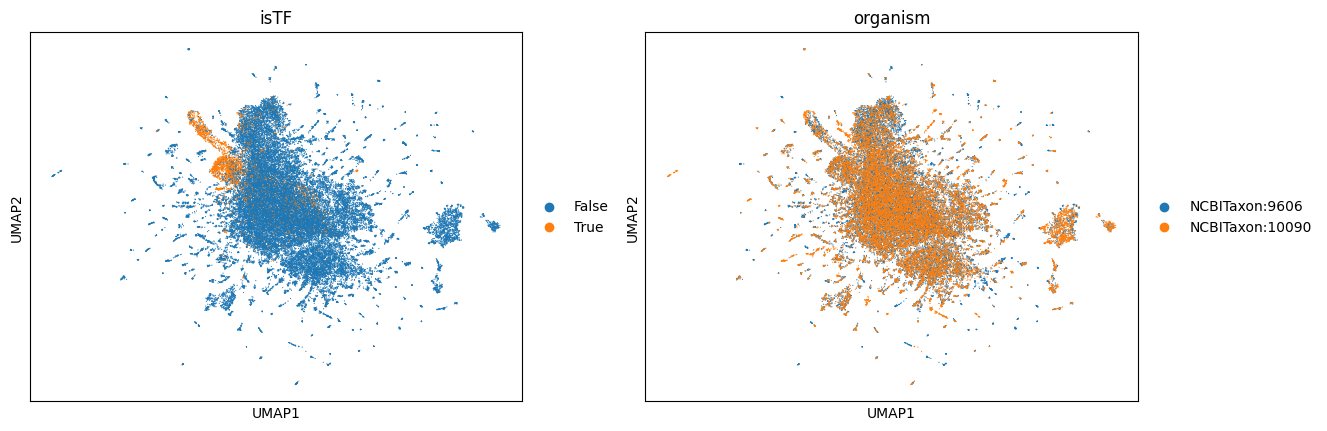

In [21]:
sc.pp.neighbors(adata_prev, use_rep='X')
sc.tl.umap(adata_prev)
sc.pl.embedding(adata_prev, basis='umap', color=['isTF', 'organism'])

In [22]:
x = model.gene_encoder[0].embeddings.weight
for layer in model.gene_encoder[1:]:
    x = layer(x)
x = x.data.cpu().numpy()

In [23]:
adata = AnnData(pd.DataFrame(data=x, index=model.genes, columns=list(range(512))))
adata = adata[adata.obs.index.isin(genedf.index)]
adata.obs = genedf.loc[adata.obs.index]
adata.obs['isTF'] = False
adata.obs.loc[genedf.symbol.isin(TF) | genedf.symbol.isin(mTF), 'isTF'] = True
adata

AnnData object with n_obs × n_vars = 44741 × 512
    obs: 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'synonyms', 'description', 'organism_id', 'mt', 'ribo', 'hb', 'organism', 'isTF'

/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
... storing 'symbol' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'description' as categorical
... storing 'organism' as categorical


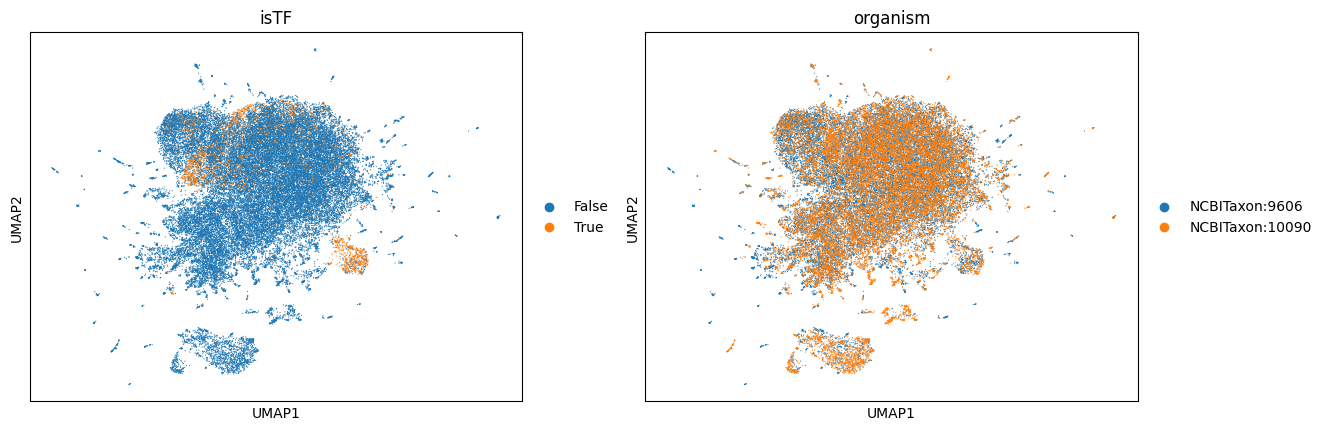

In [24]:
sc.pp.neighbors(adata, use_rep='X')
sc.tl.umap(adata)
sc.pl.embedding(adata, basis='umap', color=['isTF', 'organism'])

In [6]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [12]:
markers = set(i for u in gp.get_library(name="Tabula_Sapiens").values() for i in u)
len(markers)

[d3graph] INFO> Downloading and generating Enrichr library gene sets...


In [ ]:
go_mf = gp.get_library(name='GO_Biological_Process_2025', organism='Human')

In [30]:
adata.obs['GO_Regulation of Cell Division'] = adata.obs.symbol.str.lower().isin([i.lower() for i in go_mf['Regulation of Cell Division (GO:0051302)']])
adata_prev.obs['GO_Regulation of Cell Division'] = adata_prev.obs.symbol.str.lower().isin([i.lower() for i in go_mf['Regulation of Cell Division (GO:0051302)']])

In [14]:
go_mf = gp.get_library(name='MSigDB_Hallmark_2020', organism='Human')
# GO_Biological_Process_2025


[d3graph] INFO> Downloading and generating Enrichr library gene sets...


In [56]:
go_mf.keys()

dict_keys(['TNF-alpha Signaling via NF-kB', 'Hypoxia', 'Cholesterol Homeostasis', 'Mitotic Spindle', 'Wnt-beta Catenin Signaling', 'TGF-beta Signaling', 'IL-6/JAK/STAT3 Signaling', 'DNA Repair', 'G2-M Checkpoint', 'Apoptosis', 'Notch Signaling', 'Adipogenesis', 'Estrogen Response Early', 'Estrogen Response Late', 'Androgen Response', 'Myogenesis', 'Protein Secretion', 'Interferon Alpha Response', 'Interferon Gamma Response', 'Apical Junction', 'Apical Surface', 'Hedgehog Signaling', 'Complement', 'Unfolded Protein Response', 'PI3K/AKT/mTOR  Signaling', 'mTORC1 Signaling', 'E2F Targets', 'Myc Targets V1', 'Myc Targets V2', 'Epithelial Mesenchymal Transition', 'Inflammatory Response', 'Xenobiotic Metabolism', 'Fatty Acid Metabolism', 'Oxidative Phosphorylation', 'Glycolysis', 'Reactive Oxygen Species Pathway', 'p53 Pathway', 'UV Response Up', 'UV Response Dn', 'Angiogenesis', 'heme Metabolism', 'Coagulation', 'IL-2/STAT5 Signaling', 'Bile Acid Metabolism', 'Pperoxisome', 'Allograft Rejec

In [25]:
adata.obs['Inflammatory Response'] = adata.obs.symbol.str.lower().isin([i.lower() for i in go_mf['Inflammatory Response']])
adata_prev.obs['Inflammatory Response'] = adata_prev.obs.symbol.str.lower().isin([i.lower() for i in go_mf['Inflammatory Response']])
adata.obs['Apoptosis'] = adata.obs.symbol.str.lower().isin([i.lower() for i in go_mf['Apoptosis']])
adata_prev.obs['Apoptosis'] = adata_prev.obs.symbol.str.lower().isin([i.lower() for i in go_mf['Apoptosis']])
adata.obs['markers'] = adata.obs.symbol.str.lower().isin([i.lower() for i in markers])
adata_prev.obs['markers'] = adata_prev.obs.symbol.str.lower().isin([i.lower() for i in markers])

In [27]:
from sklearn.metrics.pairwise import cosine_distances
import numpy as np



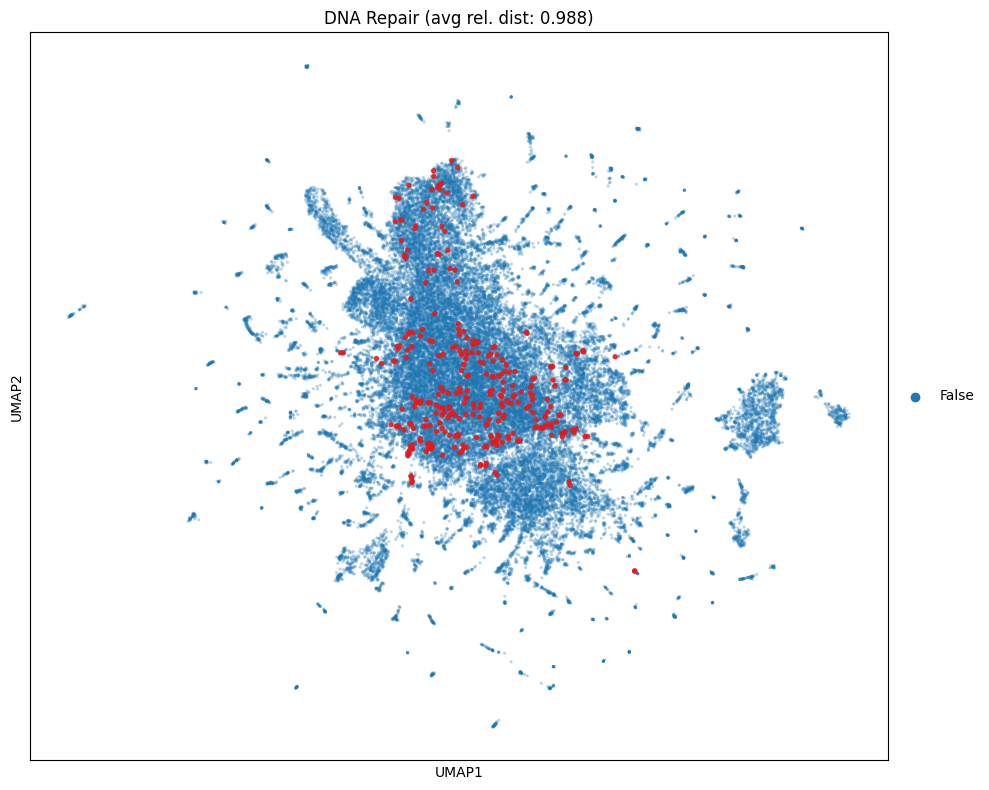

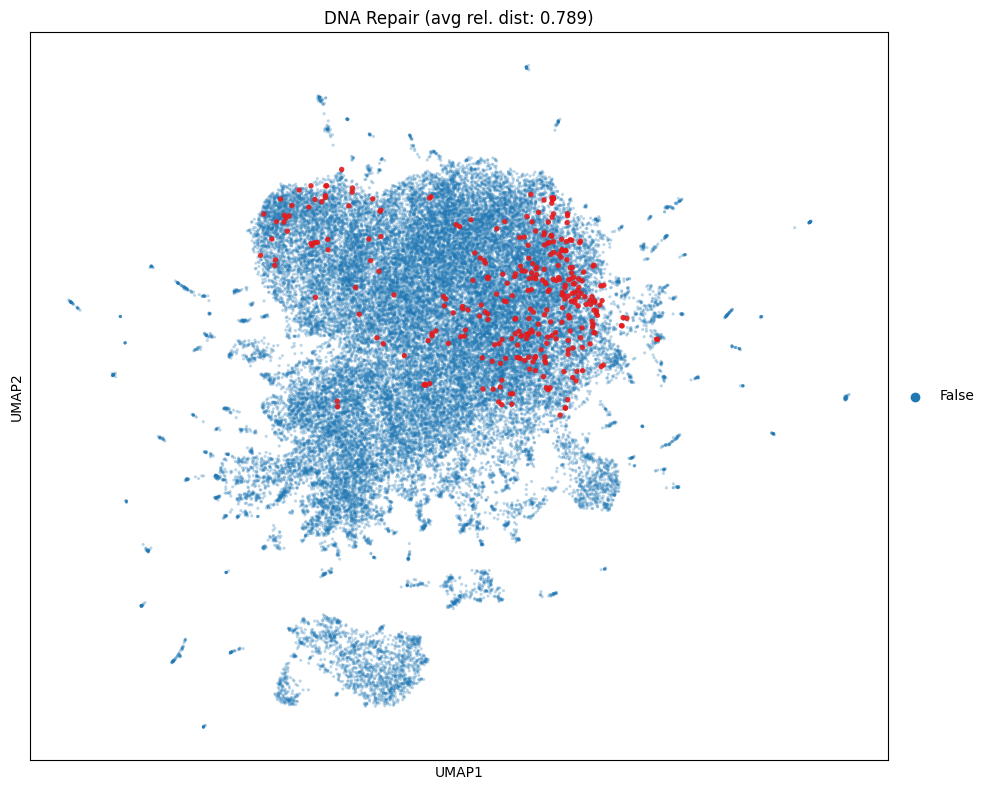

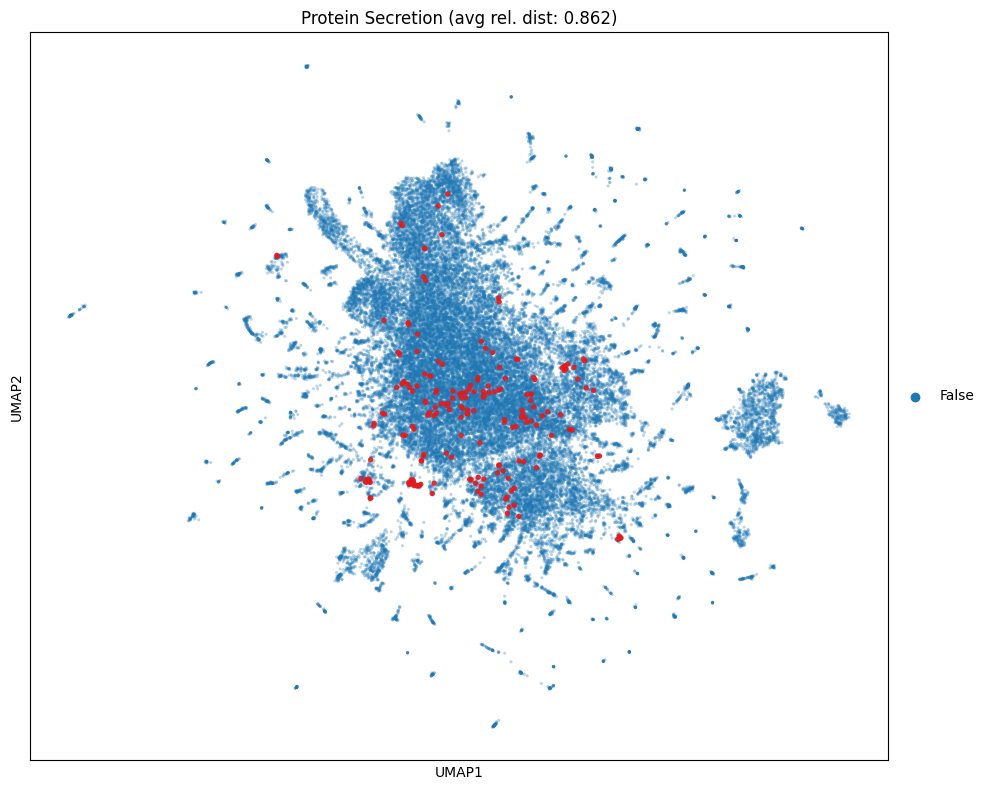

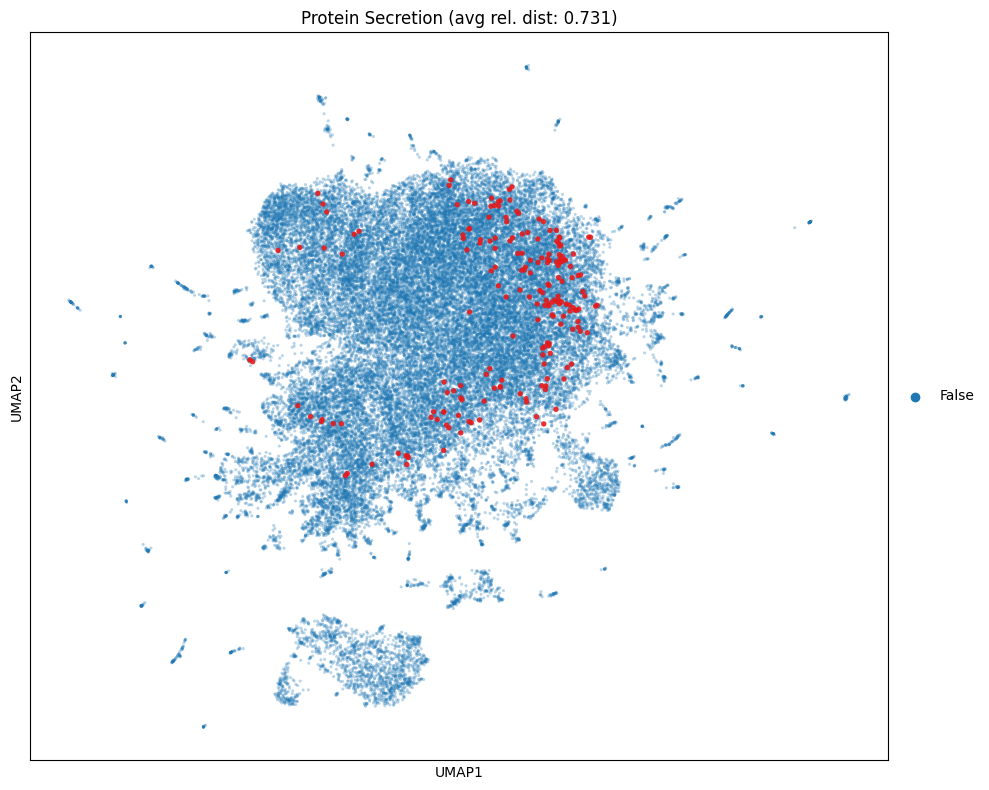

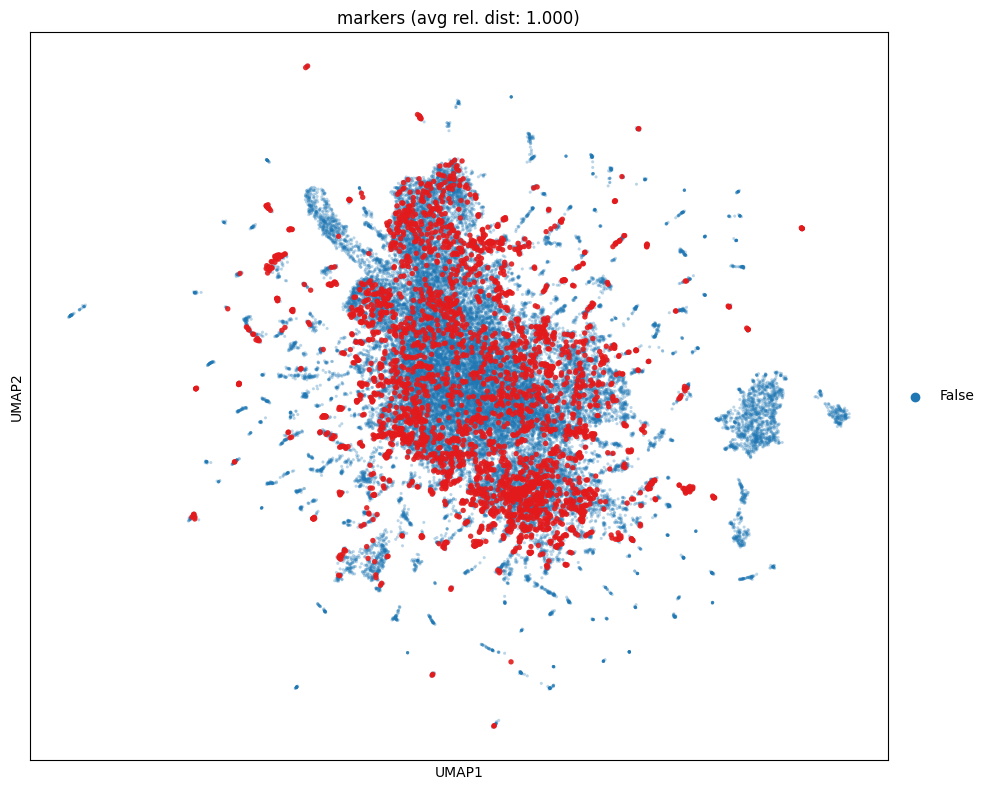

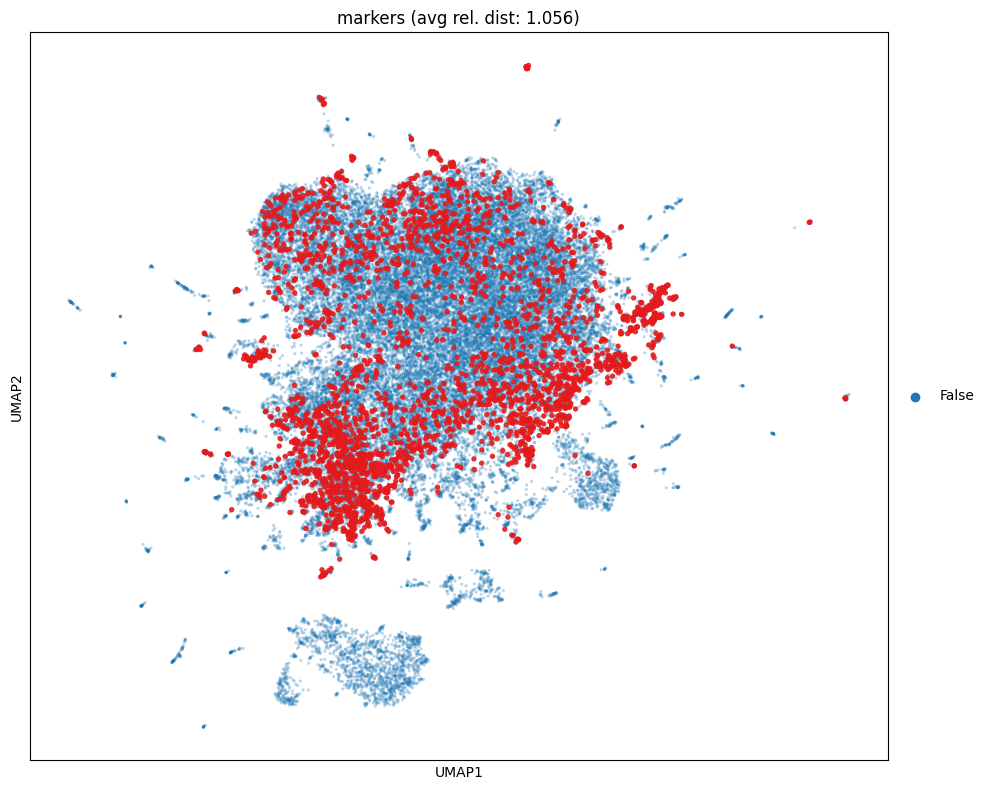

In [29]:
for i in ['DNA Repair', 'Protein Secretion', 'markers']:
        # Get the subset of data for genes in category i
        # Get subset of data for genes in category i
        subset_X = adata_prev[adata_prev.obs[i]].X

        # Get random subset of same size for normalization
        n_genes = subset_X.shape[0]
        random_idx = np.random.choice(adata_prev.shape[0], size=n_genes, replace=False)
        random_X = adata_prev[random_idx].X

        # Compute pairwise cosine distances for both subsets
        distances = cosine_distances(subset_X)
        random_distances = cosine_distances(random_X)

        # Calculate average distances (excluding self-distances on diagonal)
        n = distances.shape[0]
        avg_dist = (distances.sum() - n) / (n * n - n)
        avg_random = (random_distances.sum() - n) / (n * n - n)

        # Return normalized average distance
        normalized_dist_prev = avg_dist / avg_random
        normalized_dist_prev
        # Get subset of data for genes in category i
        subset_X = adata[adata.obs[i]].X

        # Get random subset of same size for normalization
        n_genes = subset_X.shape[0]
        random_idx = np.random.choice(adata.shape[0], size=n_genes, replace=False)
        random_X = adata[random_idx].X

        # Compute pairwise cosine distances for both subsets
        distances = cosine_distances(subset_X)
        random_distances = cosine_distances(random_X)

        # Calculate average distances (excluding self-distances on diagonal)
        n = distances.shape[0]
        avg_dist = (distances.sum() - n) / (n * n - n)
        avg_random = (random_distances.sum() - n) / (n * n - n)

        # Return normalized average distance
        normalized_dist = avg_dist / avg_random
        normalized_dist
        fig, ax = plt.subplots(figsize=(10, 8))

        # First plot all non-inflammatory genes with reduced opacity
        sc.pl.umap(adata_prev[~adata_prev.obs[i]], 
                color=i,
                alpha=0.3,  # Even lighter background
                size=20,     # Smaller background points
                show=False,
                ax=ax,
                title=f"{i} (avg rel. dist: {normalized_dist_prev:.3f})",
                legend_loc='right margin')

        # Then plot inflammatory genes on top with full opacity
        sc.pl.umap(adata_prev[adata_prev.obs[i]], 
                color=i,
                palette='Set1',
                alpha=0.9,   # Slightly transparent but still prominent
                size=60,    # Larger points for inflammatory genes
                show=False,
                ax=ax,
                legend_loc=None)  # Don't show duplicate legend
        
        plt.title(f"{i} (avg rel. dist: {normalized_dist_prev:.3f})")
        plt.tight_layout()
        plt.show()
        fig, ax = plt.subplots(figsize=(10, 8))

        # First plot all non-inflammatory genes with reduced opacity
        sc.pl.umap(adata[~adata.obs[i]], 
                color=i,
                alpha=0.3,  # Even lighter background
                size=20,     # Smaller background points
                show=False,
                ax=ax,
                legend_loc='right margin')

        # Then plot inflammatory genes on top with full opacity
        sc.pl.umap(adata[adata.obs[i]], 
                color=i,
                palette='Set1',
                alpha=0.9,   # Slightly transparent but still prominent
                size=60,    # Larger points for inflammatory genes
                show=False,
                ax=ax,
                legend_loc=None)  # Don't show duplicate legend
        plt.title(f"{i} (avg rel. dist: {normalized_dist:.3f})")
        plt.tight_layout()
        plt.show()

In [37]:
go_mf.keys()

dict_keys(['TNF-alpha Signaling via NF-kB', 'Hypoxia', 'Cholesterol Homeostasis', 'Mitotic Spindle', 'Wnt-beta Catenin Signaling', 'TGF-beta Signaling', 'IL-6/JAK/STAT3 Signaling', 'DNA Repair', 'G2-M Checkpoint', 'Apoptosis', 'Notch Signaling', 'Adipogenesis', 'Estrogen Response Early', 'Estrogen Response Late', 'Androgen Response', 'Myogenesis', 'Protein Secretion', 'Interferon Alpha Response', 'Interferon Gamma Response', 'Apical Junction', 'Apical Surface', 'Hedgehog Signaling', 'Complement', 'Unfolded Protein Response', 'PI3K/AKT/mTOR  Signaling', 'mTORC1 Signaling', 'E2F Targets', 'Myc Targets V1', 'Myc Targets V2', 'Epithelial Mesenchymal Transition', 'Inflammatory Response', 'Xenobiotic Metabolism', 'Fatty Acid Metabolism', 'Oxidative Phosphorylation', 'Glycolysis', 'Reactive Oxygen Species Pathway', 'p53 Pathway', 'UV Response Up', 'UV Response Dn', 'Angiogenesis', 'heme Metabolism', 'Coagulation', 'IL-2/STAT5 Signaling', 'Bile Acid Metabolism', 'Pperoxisome', 'Allograft Rejec

# Cell embs

# Using commit version: d99be21ad66ed0630a4c79ad4cadc61912a43ce0 for the simpler_flash package

## Loading the data

In [33]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


In [34]:
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
preprocessor = Preprocessor(use_layer='counts', is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False)
adata = preprocessor(adata.copy())
adata

X was not raw counts, using 'counts' layer
Dropping layers:  KeysView(Layers with keys: counts)
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 16382 renamining
filtered out 0 cells, 16382 renamining
No ENS genes found, assuming gene symbols...
Removed 0 genes.
startin QC
Seeing 4678 outliers (28.56% of total dataset):
done
AnnData object with n_obs × n_vars = 16382 × 70704
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'synonyms', 'description', 'organism_id', 'mt', 'ribo',

AnnData object with n_obs × n_vars = 16382 × 70704
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'uid', 'symbol', 'ncbi_gene_ids', 'biotype', 'synonyms', 'description', 'organism_id', 'mt', 'ribo', 'hb', 'organism', 'ensembl_gene_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'unseen_genes'

In [ ]:
adata = sc.read(
    "data/human_brain_smartv4.h5ad",
    backup_url="https://datasets.cellxgene.cziscience.com/f156b755-78c7-4928-917a-be138c153b85.h5ad",
)


  0%|          | 0.00/2.47G [00:00<?, ?B/s]

In [30]:
preprocessor = Preprocessor(force_preprocess=True, skip_validate=True, do_postp=False)
adata = preprocessor(adata.copy())
adata

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 9409 renamining
filtered out 0 cells, 9409 renamining
Removed 0 genes.
startin QC
Seeing 5471 outliers (58.15% of total dataset):
done
AnnData object with n_obs × n_vars = 9409 × 70704
    obs: 'nGene', 'nReads', 'plate.barcode', 'cell.id', 'region', 'label', 'sorter', 'sort.location', 'sample', 'location', 'donor_id', 'percent.ercc', 'percent.ribo', 'gating', 'free_annotation', 'Number of splices: Total', 'Number of splices: Annotated (sjdb)', 'Number of splices: GT-AG', 'Number of splices: GC-AG', 'Number of splices: AT-AC', 'Number of splices: Non-canonical', 'Mapping speed, Million of reads per hour', 'Average input read length', 'compartment', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_o

AnnData object with n_obs × n_vars = 9409 × 70704
    obs: 'nGene', 'nReads', 'plate.barcode', 'cell.id', 'region', 'label', 'sorter', 'sort.location', 'sample', 'location', 'donor_id', 'percent.ercc', 'percent.ribo', 'gating', 'free_annotation', 'Number of splices: Total', 'Number of splices: Annotated (sjdb)', 'Number of splices: GT-AG', 'Number of splices: GC-AG', 'Number of splices: AT-AC', 'Number of splices: Non-canonical', 'Mapping speed, Million of reads per hour', 'Average input read length', 'compartment', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n

# good dataset

In [4]:
embed = Embedder(how="random expr", max_len=4000, num_workers=16, pred_embedding = ["cell_type_ontology_term_id"])

In [5]:
#cell type
adata, metrics = embed(model, adata, cache=False)

NameError: name 'model' is not defined

In [ ]:
bm = Benchmarker(
    adata,
    batch_key="tech", #batch, tech
    label_key="celltype", #celltype
    embedding_obsm_keys=["scprint_emb"],
    bio_conservation_metrics=BioConservation(isolated_labels=False),
    batch_correction_metrics=BatchCorrection(),
    n_jobs=20,
)
bm.benchmark()

[autoreload of jaxlib.mlir.ir failed: Traceback (most recent call last):
  File "/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/jaxlib/mlir/ir.py", line 25, in <module>
    def _affineMapAttr(x, context):
  File "/home/ml4ig1/miniconda3/envs/scprnt2/lib/python3.10/site-packages/jaxlib/mlir/ir.p

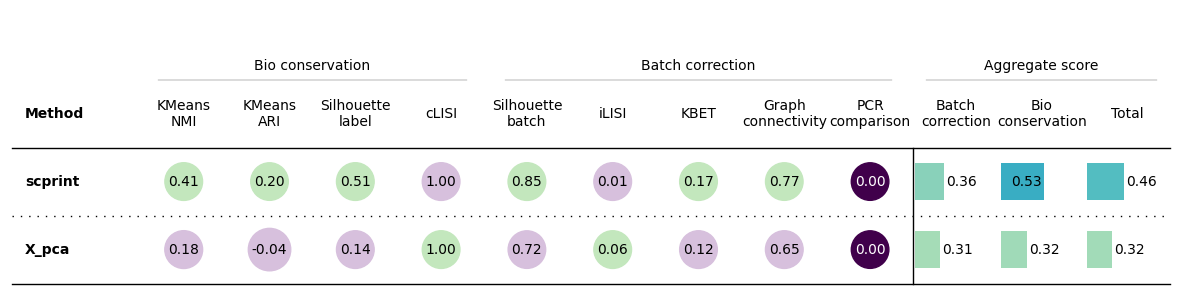

In [ ]:
# results esm2
bm.plot_results_table(min_max_scale=False)

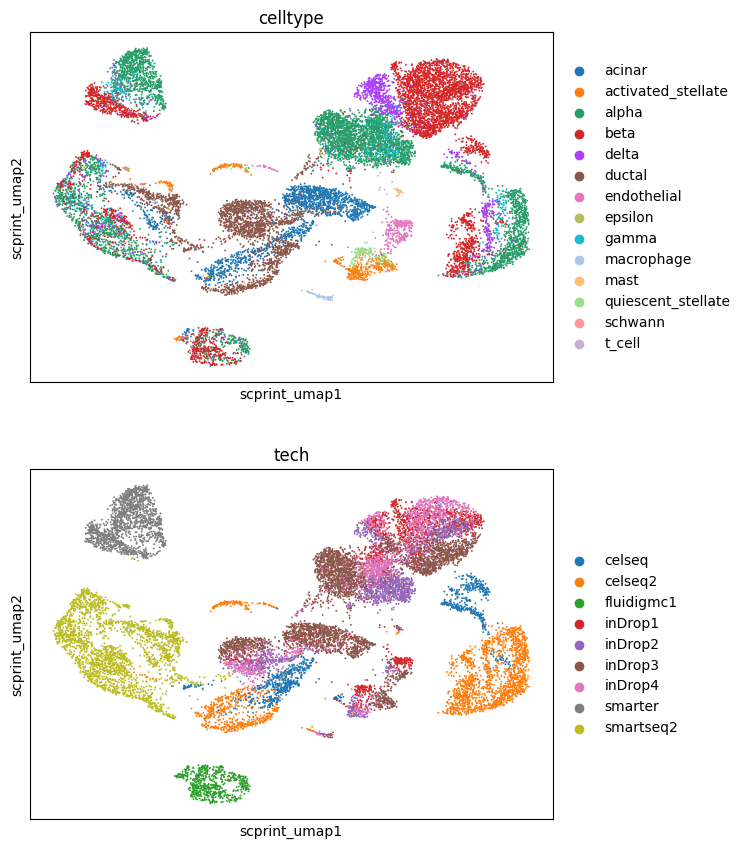

In [ ]:
sc.pl.embedding(adata, basis="scprint_umap", color=["celltype", "tech"], ncols=1)

In [ ]:
# results cell transformer
bm.plot_results_table(min_max_scale=False)

In [ ]:
sc.pl.embedding(adata, basis="scprint_umap", color=["celltype", "tech"], ncols=1)

In [ ]:
# results normal
bm.plot_results_table(min_max_scale=False)